# **Proyecto 1: Clasificación de ODSs**
## **Integrantes**
* **Líder de Proyecto:** Juan Esteban Álvarez García - 202212030
* **Líder de Negocio:** Camilo Inoue Rudas - 202225593
* **Líder de Datos:** Juan Esteban Álvarez García - 202212030
* **Líder de Analítica:** Ivan Arturo Avila Gomez - 202216280

## **Etapa 1: Entendimiento y preparación de los datos**
Por: Juan Esteban Álvarez García

### 1 Preparación del ambiente
Instalar las librerías pertinentes

In [1]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install scikit-learn
!pip install statsmodels
!pip install scipy
!pip install seaborn
!pip install spacy
!python -m spacy download es_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 101.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


Imports y utilidades

In [2]:
# Imports esenciales
import re
import nltk
import spacy
import string
import unicodedata
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from nltk.corpus import stopwords
from sklearn.utils import resample
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Opcionales
try:
    import statsmodels.api as sm
    import statsmodels.stats.api as sms
    from statsmodels.stats.outliers_influence import OLSInfluence
    STATS_MODELS_AVAILABLE = True
except Exception:
    STATS_MODELS_AVAILABLE = False

try:
    from scipy import stats
    SCIPY_AVAILABLE = True
except Exception:
    SCIPY_AVAILABLE = False

print("statsmodels:", STATS_MODELS_AVAILABLE, "| scipy:", SCIPY_AVAILABLE)

try:
    nlp = spacy.load("es_core_news_sm")
except OSError:
    print("El modelo 'es_core_news_sm' no se ha descargado. Por favor, ejecute el comando 'python -m spacy download es_core_news_sm'")
    exit()

#Helpers
# Descargar stopwords en español si no están disponibles
nltk.download('stopwords')

# Obtener stopwords en español
stop_words_es = set(stopwords.words('spanish'))
stop_words_es.add("él")              # U+00E9 (precompuesta)
stop_words_es.add("e\u0301l")        # U+0065 U+0301 (combinada)
stop_words_es.add("Él".lower())

# Definir las palabras adicionales que quieres eliminar
nuevas_stopwords = {'él', 'si', 'ejemplo', 'puede', 'pueden', 'ser'}
posibles_stopwords = {'países', 'sistema', 'años', 'datos', 'tasa', '1', '3', '4', 'ocde', 'cada'}

# Combinar las dos listas para crear la lista final de stopwords
stop_words_final = stop_words_es.union(nuevas_stopwords)
stop_words_final = stop_words_final.union(posibles_stopwords)

def standardize(series):
    s = pd.Series(series)
    return (s - s.mean())/s.std(ddof=1)

def ver_balance(df):
    # Conteo
    conteos = df['labels'].value_counts()
    print("Conteos:", conteos)

    # Proporción
    porcentajes = df['labels'].value_counts(normalize=True) * 100
    print("Porcentajes:", porcentajes.round(2))

def balancear_dataset_oversampling(df, columna_target='labels'):
    # Encontrar la clase con más muestras (para balancear hacia ella)
    distribucion_original = df[columna_target].value_counts()
    clase_referencia = distribucion_original.idxmax()
    tamaño_objetivo = distribucion_original.max()

    # Lista para almacenar DataFrames balanceados
    dfs_balanceados = []

    # Balancear cada clase
    for clase in df[columna_target].unique():
        df_clase = df[df[columna_target] == clase]

        if len(df_clase) < tamaño_objetivo:
            # Aplicar oversampling a clases minoritarias
            df_clase_balanced = resample(
                df_clase,
                replace=True,
                n_samples=tamaño_objetivo,
                random_state=42
            )
            dfs_balanceados.append(df_clase_balanced)
            print(f"Clase {clase}: {len(df_clase)} → {len(df_clase_balanced)}")
        else:
            # Mantener clases mayoritarias
            dfs_balanceados.append(df_clase)
            print(f"Clase {clase}: {len(df_clase)} (mantenida)")

    # Combinar y mezclar
    df_balanced = pd.concat(dfs_balanceados, ignore_index=True)
    df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

    return df_balanced

def preprocesar_texto(texto):
    if pd.isna(texto) or texto == '' or texto.isspace():
        return ''

    texto = str(texto)

    # Normalizar Unicode: convertir caracteres a su forma normalizada
    texto = unicodedata.normalize("NFC", texto)

    # Convertir a minúsculas
    texto = texto.lower()

    # Eliminar puntuación y caracteres especiales
    texto = texto.translate(str.maketrans('', '', string.punctuation))

    # Eliminar números
    texto = re.sub(r'\d+', '', texto)

    # Eliminar URLs
    texto = re.sub(r'http\S+', '', texto)

    # Eliminar menciones y hashtags (pero mantener el texto)
    texto = re.sub(r'@\w+', '', texto)
    texto = re.sub(r'#', '', texto)

    # Eliminar caracteres especiales pero mantener letras con acentos y espacios
    texto = re.sub(r'[^\wáéíóúñüàèìòùäëïöü\s]', ' ', texto)

    # Reemplazar múltiples espacios por uno solo
    texto = re.sub(r'\s+', ' ', texto)

    # Eliminar espacios al inicio y final
    texto = texto.strip()

    return texto

def contar_palabras(texto):
    if texto == '' or texto is None:
        return 0

    # Dividir el texto en palabras
    palabras = texto.split()

    # Filtrar palabras vacías
    palabras = [p for p in palabras if p != '']

    return len(palabras)

def generar_analisis_texto(df, columna_texto='textos', columna_conteo='num_palabras', columna_labels='labels'):
    if df.empty or columna_texto not in df.columns or columna_conteo not in df.columns:
        print("El DataFrame está vacío o faltan columnas clave ('textos' o 'num_palabras').")
        return

    # --- Gráficos generales ---
    plt.style.use('default')
    sns.set_palette("husl")

    # Crear figura con subgráficos para los gráficos generales
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Análisis de Distribución de Textos', fontsize=16)

    # Histograma 1: Distribución general de longitud de textos
    axes[0, 0].hist(df[columna_conteo], bins=30, alpha=0.7, edgecolor='black')
    axes[0, 0].set_xlabel('Número de palabras')
    axes[0, 0].set_ylabel('Frecuencia')
    axes[0, 0].set_title('Distribución de longitud de textos')
    axes[0, 0].grid(alpha=0.3)

    # Histograma 4: Palabras más comunes (primeros 20)
    todos_textos = ' '.join(df[columna_texto].tolist())
    palabras = todos_textos.split()
    contador_palabras = Counter(palabras)
    palabras_comunes = contador_palabras.most_common(20)

    if palabras_comunes:
        palabras_comunes_df = pd.DataFrame(palabras_comunes, columns=['Palabra', 'Frecuencia'])
        axes[1, 1].barh(range(len(palabras_comunes_df)), palabras_comunes_df['Frecuencia'])
        axes[1, 1].set_yticks(range(len(palabras_comunes_df)))
        axes[1, 1].set_yticklabels(palabras_comunes_df['Palabra'])
        axes[1, 1].set_xlabel('Frecuencia')
        axes[1, 1].set_title('20 palabras más comunes')
    else:
        axes[1, 1].axis('off')

    # --- Gráficos específicos para el set de entrenamiento (con labels) ---

    if columna_labels in df.columns:
        print("Columna de etiquetas encontrada. Generando análisis por categoría ODS.")

        # Histograma 2: Distribución por categoría ODS
        categorias = sorted(df[columna_labels].unique())
        for categoria in categorias:
            datos_categoria = df[df[columna_labels] == categoria][columna_conteo]
            axes[0, 1].hist(datos_categoria, bins=20, alpha=0.7, label=f'ODS {categoria}', density=True)

        axes[0, 1].set_xlabel('Número de palabras')
        axes[0, 1].set_ylabel('Densidad')
        axes[0, 1].set_title('Distribución por categoría ODS (normalizada)')
        axes[0, 1].legend()
        axes[0, 1].grid(alpha=0.3)

        # Histograma 3: Boxplot por categoría
        data_plot = [df[df[columna_labels] == cat][columna_conteo] for cat in categorias]
        axes[1, 0].boxplot(data_plot, labels=[f'ODS {cat}' for cat in categorias])
        axes[1, 0].set_ylabel('Número de palabras')
        axes[1, 0].set_title('Boxplot de longitud por categoría ODS')
        axes[1, 0].grid(alpha=0.3)

        # --- Gráficos adicionales: Frecuencia por ODS y palabras comunes ---
        plt.style.use('ggplot')
        top_words_por_ods = {}

        for etiqueta in categorias:
            df_clase = df[df[columna_labels] == etiqueta]
            texto_completo = ' '.join(df_clase[columna_texto].tolist())
            frecuencias = Counter(texto_completo.split())
            palabras_comunes = frecuencias.most_common(50) # Usar 50 para el análisis de solapamiento
            top_words_por_ods[etiqueta] = {p[0] for p in palabras_comunes}

            if palabras_comunes:
                palabras, conteos = zip(*palabras_comunes)
                plt.figure(figsize=(10, 6))
                plt.bar(np.arange(len(palabras)), conteos, color='blue')
                plt.xticks(np.arange(len(palabras)), palabras, rotation=45, ha='right')
                plt.title(f'Frecuencia de las 50 palabras más comunes para ODS {etiqueta}', fontsize=16)
                plt.ylabel('Frecuencia', fontsize=12)
                plt.xlabel('Palabras', fontsize=12)
                plt.tight_layout()
                plt.show()

        # --- Encontrar y listar palabras que se repiten en el top 50 de todas las categorías ---
        if len(top_words_por_ods) > 1:
            # Obtener el primer conjunto
            common_words_set = next(iter(top_words_por_ods.values()))

            # Calcular la intersección con el resto de los conjuntos
            for words_set in top_words_por_ods.values():
                common_words_set = common_words_set.intersection(words_set)

            common_words_list = list(common_words_set)

            print("\n-------------------------------------------------------------")
            print("Palabras comunes en el top 50 de cada ODS:")
            if common_words_list:
                print(common_words_list)
            else:
                print("No se encontraron palabras que se repitan en el top 50 de todos los ODS.")
            print("-------------------------------------------------------------")

    else:
        # Ocultar los subplots si no hay etiquetas
        axes[0, 1].axis('off')
        axes[1, 0].axis('off')
        print("No se encontró la columna de etiquetas. Saltando análisis por categoría.")

    plt.tight_layout()
    plt.show()

    # Estadísticas adicionales
    print("\nEstadísticas de longitud de textos:")
    print(f" - Total de textos: {len(df)}")
    print(f" - Palabras mínimas: {df[columna_conteo].min()}")
    print(f" - Palabras máximas: {df[columna_conteo].max()}")
    print(f" - Promedio de palabras: {df[columna_conteo].mean():.2f}")
    print(f" - Mediana de palabras: {df[columna_conteo].median()}")

    if columna_labels in df.columns:
        print("\nEstadísticas por categoría ODS:")
        stats_por_ods = df.groupby(columna_labels)[columna_conteo].agg(['mean', 'median', 'count']).round(2)
        print(stats_por_ods)

def eliminar_stopwords(texto):
    palabras = texto.split()
    palabras_filtradas = [p for p in palabras if p not in stop_words_final]

    return ' '.join(palabras_filtradas)

def lematizar_texto(texto):
    # Procesar el texto con spaCy
    doc = nlp(texto)
    # Obtener el lema de cada token y unirlos en una cadena
    lemas = [token.lemma_ for token in doc]
    return " ".join(lemas)

statsmodels: True | scipy: True


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### 1.1 Vistazo al Dataset
Cargar el dataset y sus variables

In [3]:
# Cargar el dataset
df_train_read = pd.read_excel('./Datos_proyecto.xlsx')

# Mostrar la información de los dataframes
df_train_read.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2424 entries, 0 to 2423
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   textos  2424 non-null   object
 1   labels  2424 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 38.0+ KB


### 1.2 Tipar los datos
Convertir los textos de tipo object a tipo string.

A partir de ahora se elige trabajar con los datos de entrenamiento.

Al finalizar el trabajo, se replicará lo mismo con los datos de prueba.

In [4]:
# Convertir la columna de textos de tipo object a string
df_train_read['textos'] = df_train_read['textos'].astype(pd.StringDtype())

# Elegir un dataset
df = df_train_read

# Mostrar el dataset
# Forma
print("Forma del dataset:", df.shape)
# Tipos de datos
display(df.dtypes)
# Primeros 10 registros
df.head(10)

Forma del dataset: (2424, 2)


,0
textos,string[python]
labels,int64


,textos,labels
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4
1,Para los niños más pequeños (bebés y niños peq...,4
2,"Además, la formación de especialistas en medic...",3
3,En los países de la OCDE se tiende a pasar de ...,4
4,Este grupo se centró en las personas que padec...,3
5,Los datos a nivel del sistema que no se deriva...,4
6,La principal ventaja de las evaluaciones exter...,4
7,Los pacientes pueden elegir a cualquier médico...,3
8,"De hecho, es probable que la designación de la...",4
9,"De hecho, aunque Chile y Uruguay tienen índice...",1


### 1.2.1 Primeras observaciones
No hay columnas duplicadas ni innecesarias.
Por ahora ninguna columna necesita un procesamiento especial

### 1.3 Buscar valores nulos

In [5]:
# Verificar valores nulos por columna
print("Valores nulos por columna:")
print(df.isnull().sum())

# Porcentaje de nulos por columna
print("\nPorcentaje de nulos por columna:")
print((df.isnull().sum() / len(df) * 100).round(2))

# Filas con al menos un valor nulo
filas_con_nulos = df[df.isnull().any(axis=1)]
print(f"\nNúmero de filas con valores nulos: {len(filas_con_nulos)}")

# Contar filas donde el texto es una cadena vacía ""
filas_con_texto_vacio = df[df['textos'] == '']
print(f"\nNúmero de filas con texto vacío: {len(filas_con_texto_vacio)}")

Valores nulos por columna:
textos    0
labels    0
dtype: int64

Porcentaje de nulos por columna:
textos    0.0
labels    0.0
dtype: float64

Número de filas con valores nulos: 0

Número de filas con texto vacío: 0


Dado que no hay valores nulos ni vacíos, no es necesario eliminar ninguna fila por ahora.

### 1.4 Buscar valores duplicados

In [6]:
# Verificar duplicados exactos en todas las columnas
duplicados_totales = df.duplicated()
print(f"Filas duplicadas exactas: {duplicados_totales.sum()}")

# Verificar duplicados solo en la columna de textos
duplicados_texto = df.duplicated(subset=['textos'])
print(f"Filas con texto duplicado: {duplicados_texto.sum()}")

Filas duplicadas exactas: 0
Filas con texto duplicado: 0


Dado que no hay valores duplicados, no es necesario eliminar ninguna fila por ahora.



### 1.5 Estadísticas descriptivas
Descripción de los datos

In [7]:
df.describe(include='all')

,textos,labels
count,2424,2424.000000
unique,2424,NaN
top,"De hecho, es probable que la designación de la...",NaN
freq,1,NaN
mean,NaN,3.006188
std,NaN,1.121012
min,NaN,1.000000
25%,NaN,3.000000
50%,NaN,3.000000
75%,NaN,4.000000


Distribución de las categorías objetivo

In [8]:
ver_balance(df)

Conteos: labels
4    1025
3     894
1     505
Name: count, dtype: int64
Porcentajes: labels
4    42.29
3    36.88
1    20.83
Name: proportion, dtype: float64


Dado que hay un desbalance significativo de las categorías (la mayoritaria tiene más del doble de ocurrencias de la minoritaria), se aplicará Oversampling a las categorías con menos registros para balancear el dataset

In [9]:
df = balancear_dataset_oversampling(df)

Clase 4: 1025 (mantenida)
Clase 3: 894 → 1025
Clase 1: 505 → 1025


Revisar la distribución nuevamente

In [10]:
ver_balance(df)
df.head(10)

Conteos: labels
4    1025
1    1025
3    1025
Name: count, dtype: int64
Porcentajes: labels
4    33.33
1    33.33
3    33.33
Name: proportion, dtype: float64


,textos,labels
0,"Además, el concepto de servicios para los niño...",4
1,"Entonces, ¿por qué debería adoptarse? La motiv...",1
2,Este es particularmente el caso de la agricult...,1
3,La operación contó con la cooperación de los o...,3
4,La Comisión de Calidad de la Atención del Rein...,3
5,"Hasta diciembre de 2006, se aplicaba la misma ...",1
6,El objetivo principal ha sido continuar manten...,3
7,En la medida en que las categorías de població...,1
8,Este capítulo ofrece al lector una amplia pano...,4
9,Los costes de la esquizofrenia fueron de aprox...,3


### 1.6 Procesamiento y limpieza de los datos
 Preprocesar el texto a lowercase, eliminar puntuación, caracteres especiales, normalizar espacios, eliminar acentos y aplicar otras transformaciones necesarias.

In [11]:
df['textos'] = df['textos'].apply(preprocesar_texto)

Añadir una columna con la cantidad de palabras por texto

In [12]:
df['num_palabras'] = df['textos'].apply(contar_palabras)
df.head(10)

,textos,labels,num_palabras
0,además el concepto de servicios para los niños...,4,90
1,entonces por qué debería adoptarse la motivaci...,1,62
2,este es particularmente el caso de la agricult...,1,146
3,la operación contó con la cooperación de los o...,3,144
4,la comisión de calidad de la atención del rein...,3,89
5,hasta diciembre de se aplicaba la misma variac...,1,120
6,el objetivo principal ha sido continuar manten...,3,89
7,en la medida en que las categorías de població...,1,133
8,este capítulo ofrece al lector una amplia pano...,4,54
9,los costes de la esquizofrenia fueron de aprox...,3,167


### 1.7 Visualización de la distribución de las palabras
Construcción de gráficas para la visualización de la distribución de palabras

Columna de etiquetas encontrada. Generando análisis por categoría ODS.


/tmp/ipython-input-1990278024.py:211: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 0].boxplot(data_plot, labels=[f'ODS {cat}' for cat in categorias])


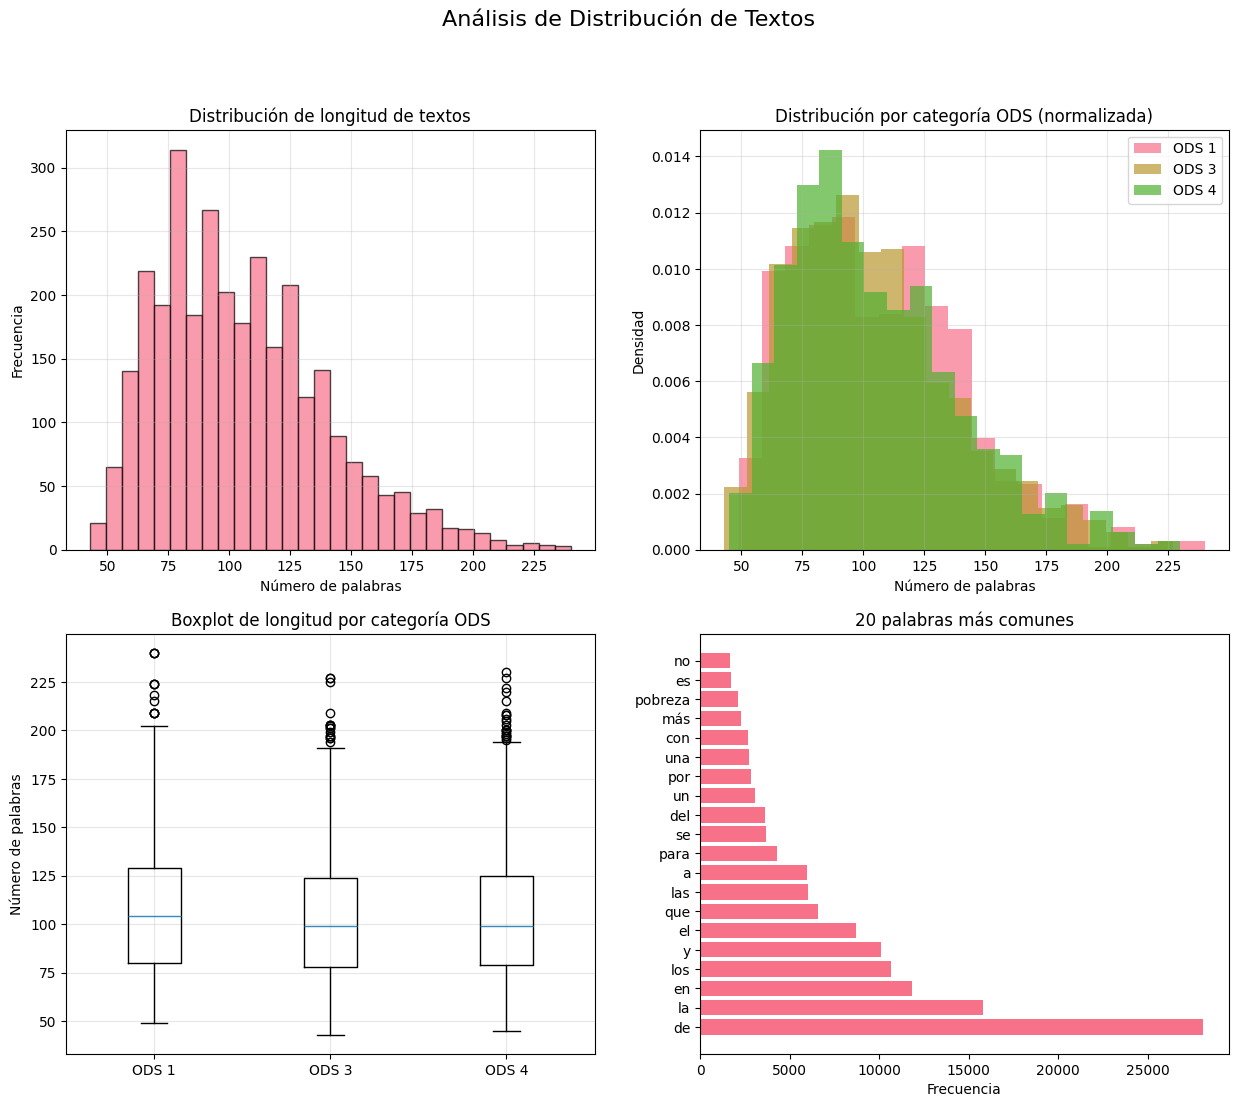

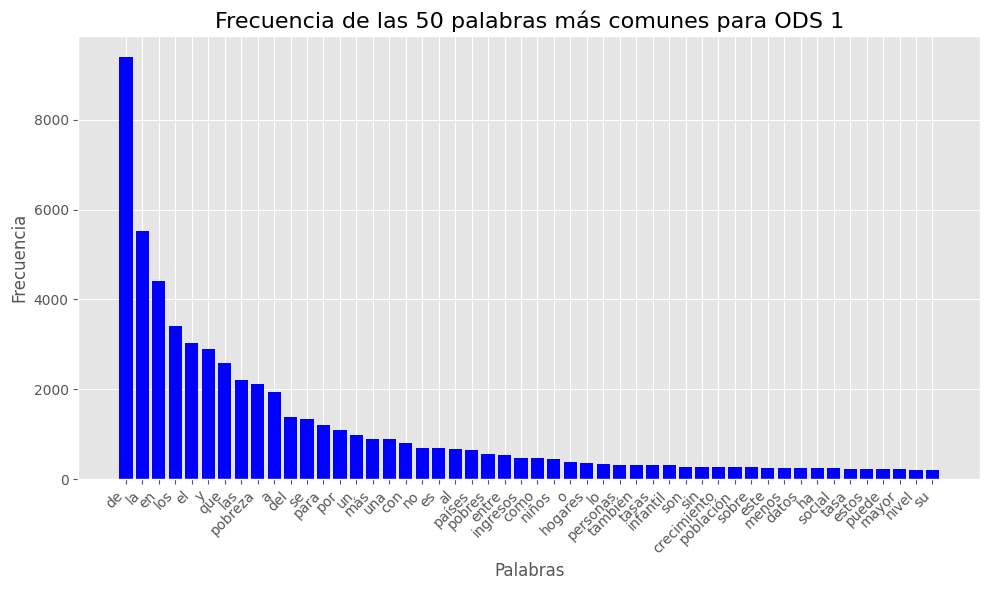

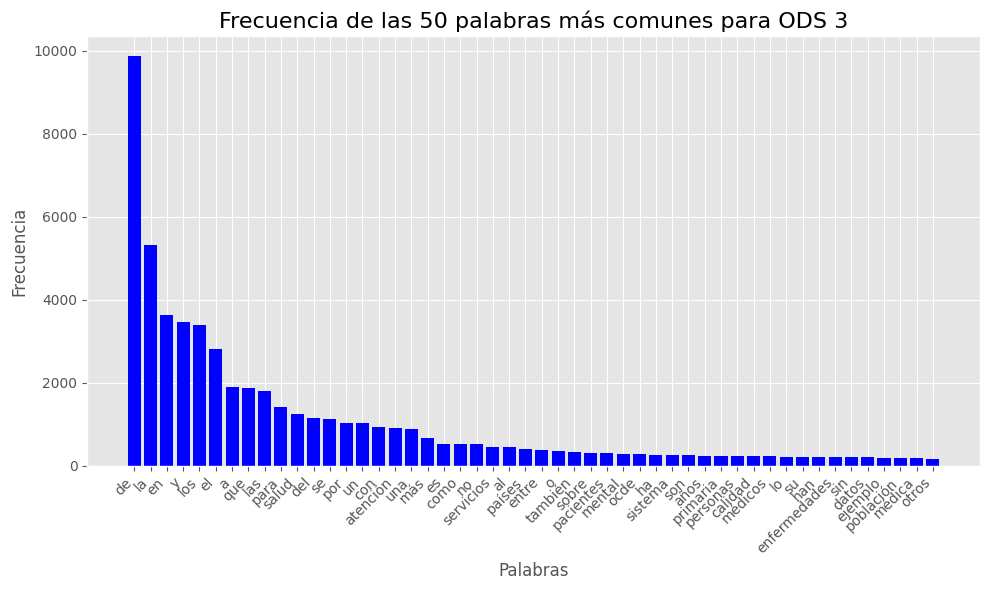

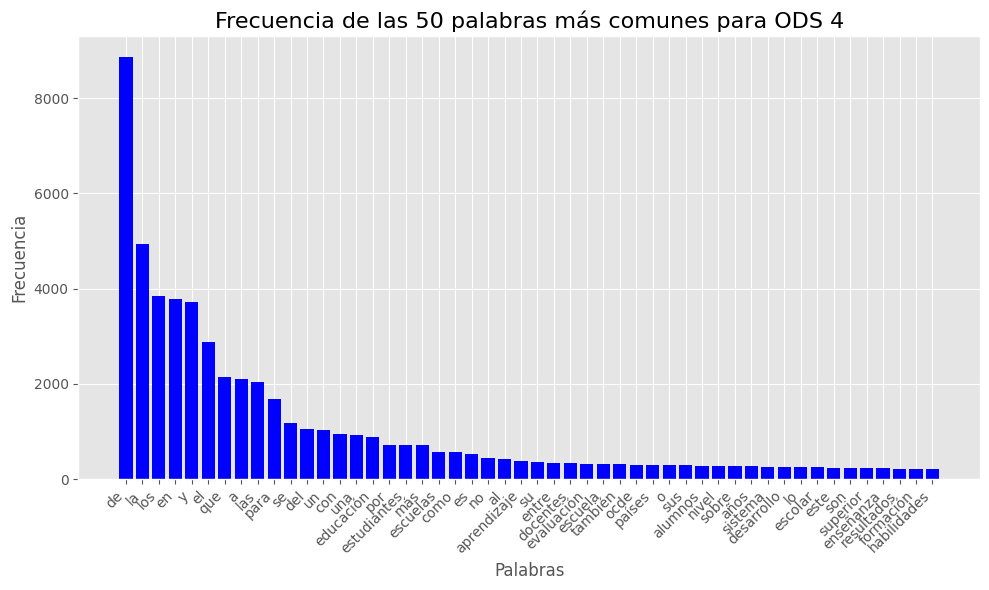


-------------------------------------------------------------
Palabras comunes en el top 50 de cada ODS:
['un', 'no', 'de', 'son', 'países', 'una', 'entre', 'lo', 'es', 'al', 'como', 'del', 'las', 'los', 'que', 'se', 'también', 'a', 'en', 'y', 'su', 'más', 'sobre', 'por', 'para', 'o', 'la', 'con', 'el']
-------------------------------------------------------------


<Figure size 640x480 with 0 Axes>


Estadísticas de longitud de textos:
 - Total de textos: 3075
 - Palabras mínimas: 43
 - Palabras máximas: 240
 - Promedio de palabras: 105.15
 - Mediana de palabras: 100.0

Estadísticas por categoría ODS:
          mean  median  count
labels                       
1       107.03   104.0   1025
3       103.94    99.0   1025
4       104.49    99.0   1025


In [13]:
generar_analisis_texto(df)

### 1.8 Eliminación de stopwords
Dada la gran cantidad de palabras de parada, se decide deshacerse de ellas para eliminar ruido y dejar las palabras más significativas en cada registro.

In [14]:
df['textos'] = df['textos'].apply(eliminar_stopwords)
df['num_palabras'] = df['textos'].apply(contar_palabras)
df.head(10)

,textos,labels,num_palabras
0,además concepto servicios niños menores amplia...,4,38
1,entonces debería adoptarse motivación subyacen...,1,29
2,particularmente caso agricultura tierra activo...,1,71
3,operación contó cooperación organismos encarga...,3,71
4,comisión calidad atención reino unido ver secc...,3,48
5,diciembre aplicaba misma variación ambas línea...,1,57
6,objetivo principal sido continuar manteniendo ...,3,44
7,medida categorías población personas discapaci...,1,70
8,capítulo ofrece lector amplia panorámica conte...,4,27
9,costes esquizofrenia aproximadamente gbp ingla...,3,88


Visualizar gráficos de nuevo luego del procesamiento.

Columna de etiquetas encontrada. Generando análisis por categoría ODS.


/tmp/ipython-input-1990278024.py:211: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 0].boxplot(data_plot, labels=[f'ODS {cat}' for cat in categorias])


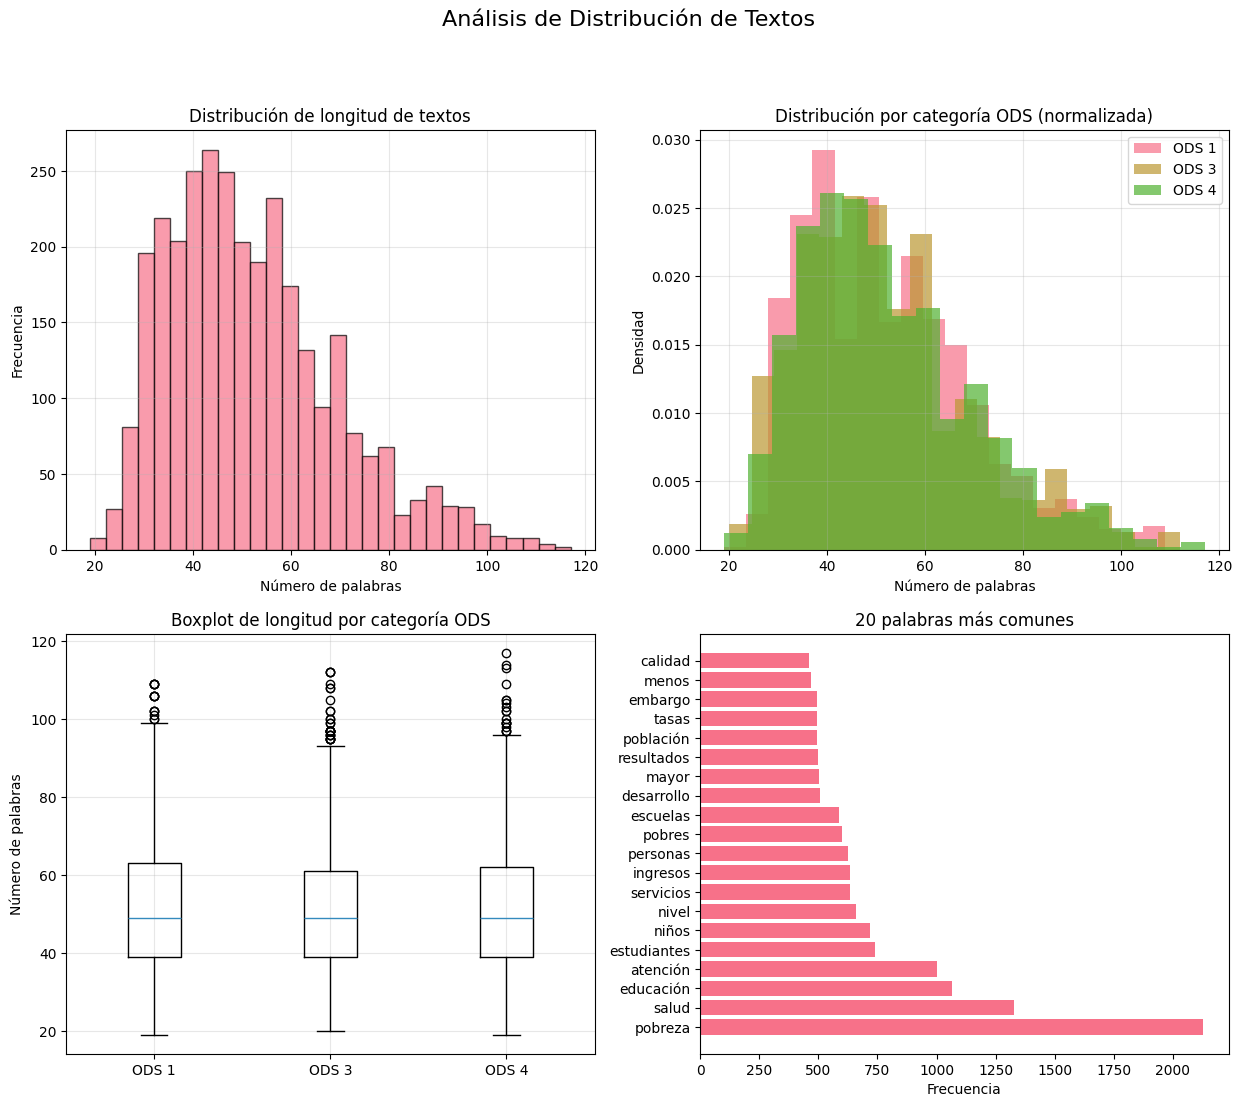

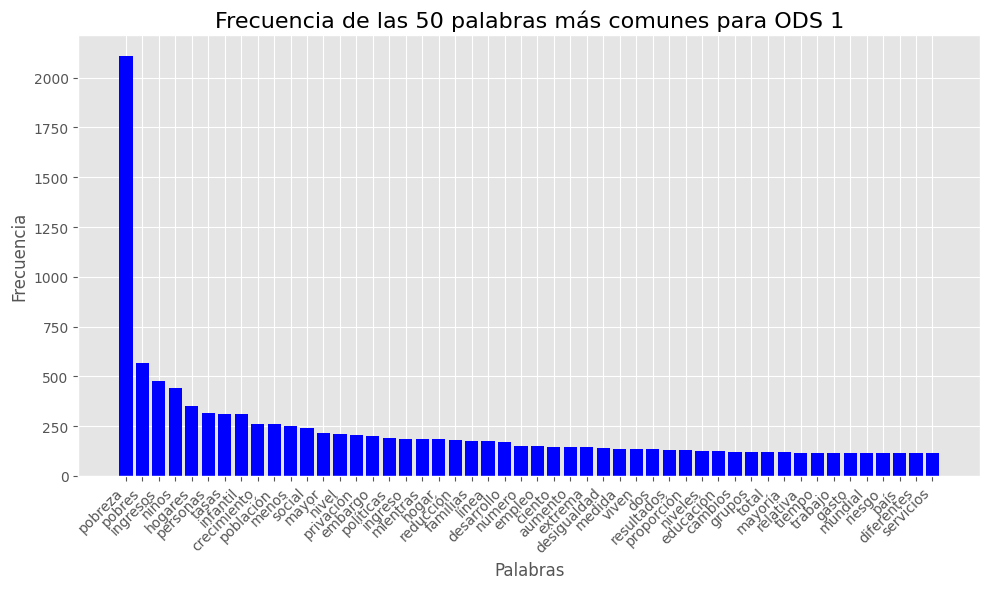

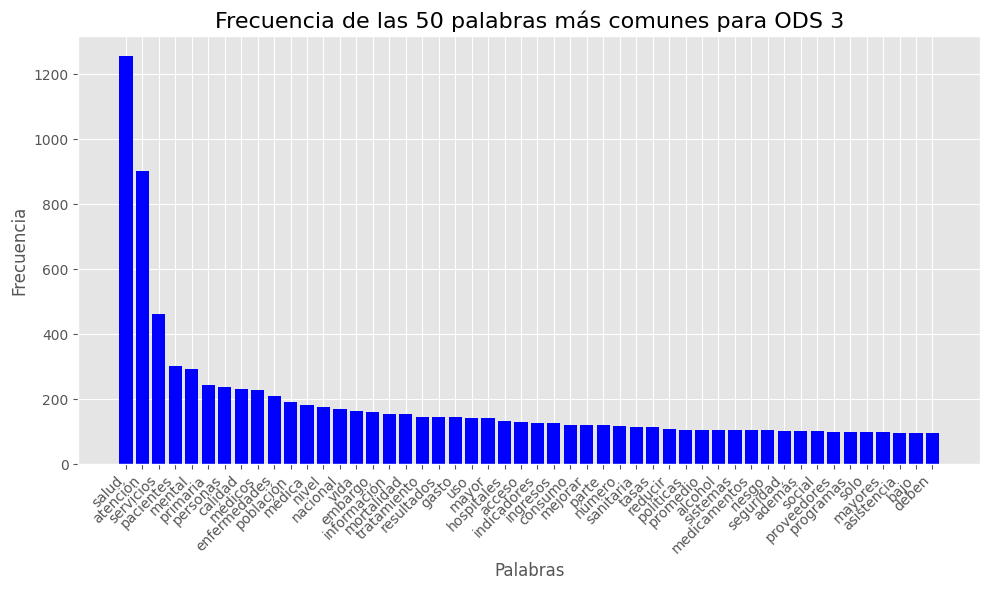

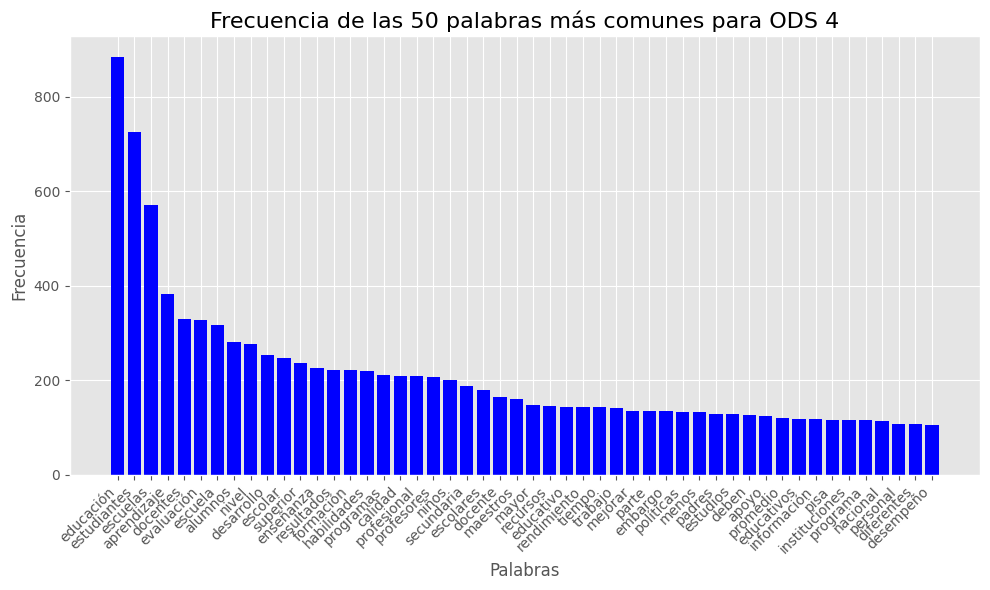


-------------------------------------------------------------
Palabras comunes en el top 50 de cada ODS:
['resultados', 'políticas', 'nivel', 'embargo', 'mayor']
-------------------------------------------------------------


<Figure size 640x480 with 0 Axes>


Estadísticas de longitud de textos:
 - Total de textos: 3075
 - Palabras mínimas: 19
 - Palabras máximas: 117
 - Promedio de palabras: 52.00
 - Mediana de palabras: 49.0

Estadísticas por categoría ODS:
         mean  median  count
labels                      
1       52.00    49.0   1025
3       51.77    49.0   1025
4       52.21    49.0   1025


In [15]:
generar_analisis_texto(df)

Ahora todas las palabras con frecuencias altas son significativas y nos hemos deshecho de las palabras de parada carentes de significancia para el aprendizaje del modelo.

### 1.9 Lematización
Para disminuir la cantidad de palabras que el modelo debe aprender, y así mejorar su entendimiento, se aplica lematización a los textos procesados para consolidar palabras con ideas similares en sus lemas (ej. "pobreza", "pobre" y "pobres" sean todas tratadas como "pobre").

In [16]:
# Aplicar la función de lematización a la columna 'textos'
df['textos'] = df['textos'].apply(lematizar_texto)
df['num_palabras'] = df['textos'].apply(contar_palabras)
print(df.head(10))

                                              textos  labels  num_palabras
0  además concepto servicio niño menor ampliar pe...       4            38
1  entonces deber adoptar él motivación subyacent...       1            31
2  particularmente caso agricultura tierra activo...       1            71
3  operación contar cooperación organismo encarga...       3            71
4  comisión calidad atención reino unido ver secc...       3            48
5  diciembre aplicar mismo variación ambos línea ...       1            57
6  objetivo principal ser continuar mantener míni...       3            44
7  medido categoría población persona discapacida...       1            70
8  capítulo ofrecer lector amplio panorámico cont...       4            27
9  coste esquizofrenio aproximadamente gbp inglat...       3            88


### 1.10 Visualización final del dataframe
Todo el procesamiento sobre el dataframe está listo y se revisa una última vez el estado final del mismo.

In [17]:
print(df.shape)
print(df.info())
df.describe(include='all')

(3075, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3075 entries, 0 to 3074
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   textos        3075 non-null   object
 1   labels        3075 non-null   int64 
 2   num_palabras  3075 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 72.2+ KB
None


,textos,labels,num_palabras
count,3075,3075.000000,3075.000000
unique,2046,NaN,NaN
top,aún quedar hacer reducir tiempo esperar consul...,NaN,NaN
freq,8,NaN,NaN
mean,NaN,2.666667,52.281951
std,NaN,1.247422,17.334387
min,NaN,1.000000,19.000000
25%,NaN,1.000000,39.000000
50%,NaN,3.000000,49.000000
75%,NaN,4.000000,62.000000


Columna de etiquetas encontrada. Generando análisis por categoría ODS.


/tmp/ipython-input-1990278024.py:211: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 0].boxplot(data_plot, labels=[f'ODS {cat}' for cat in categorias])


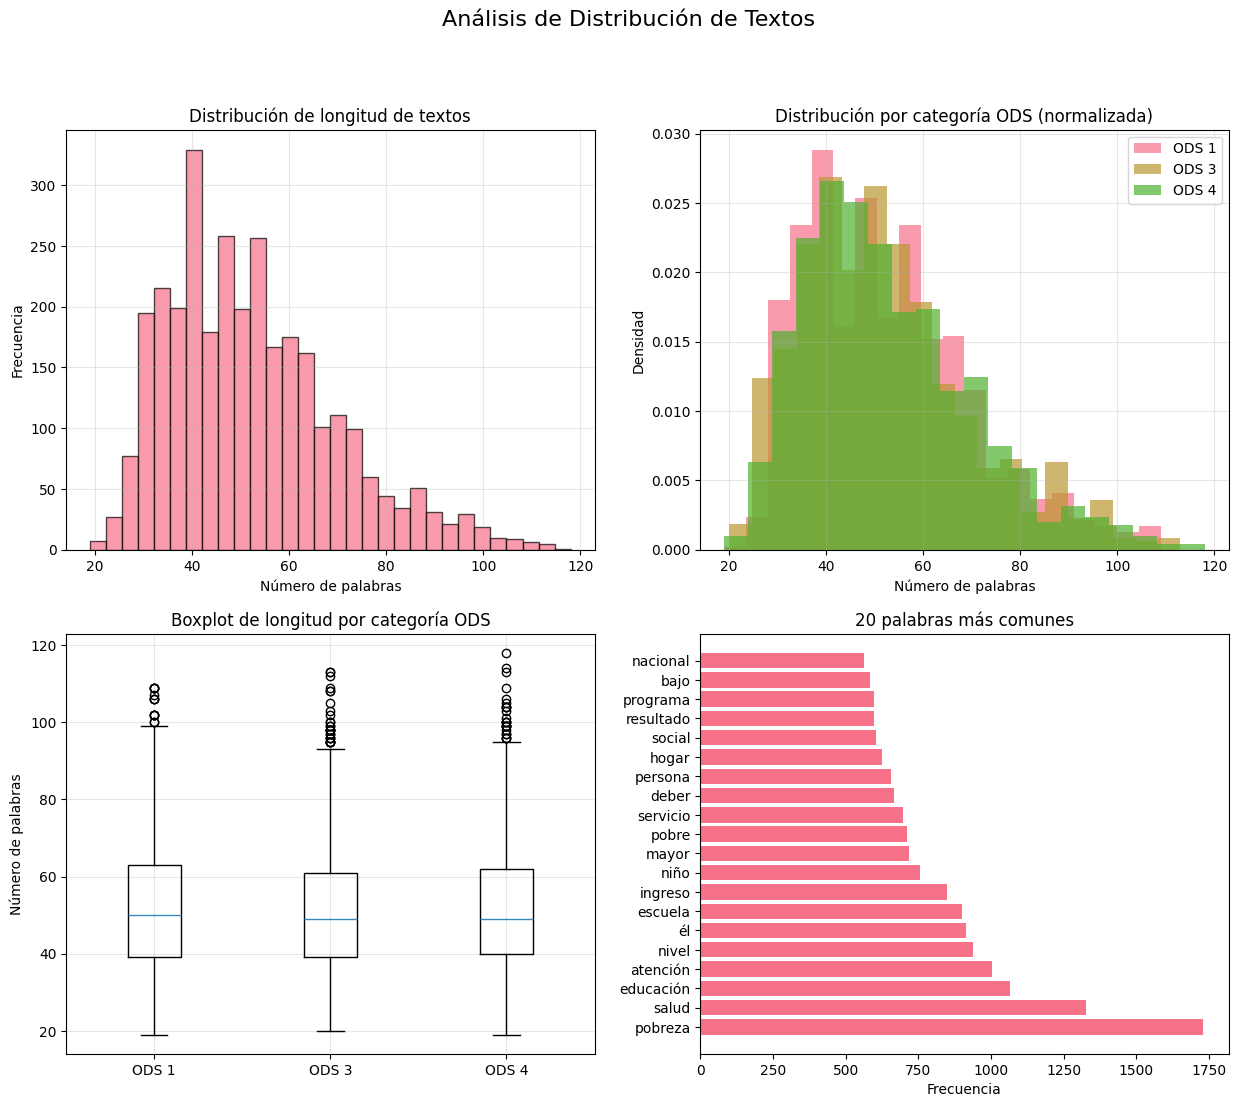

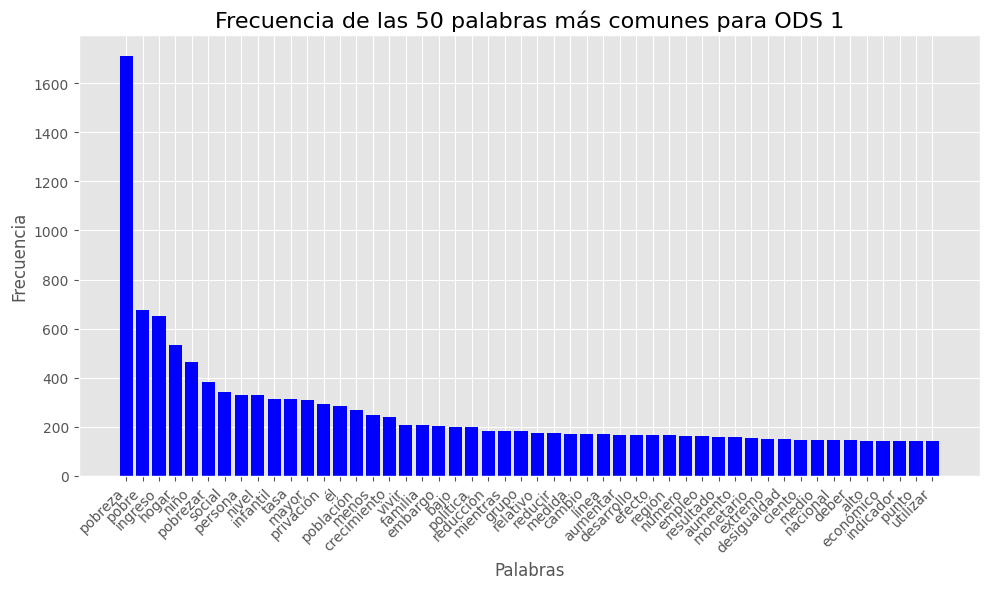

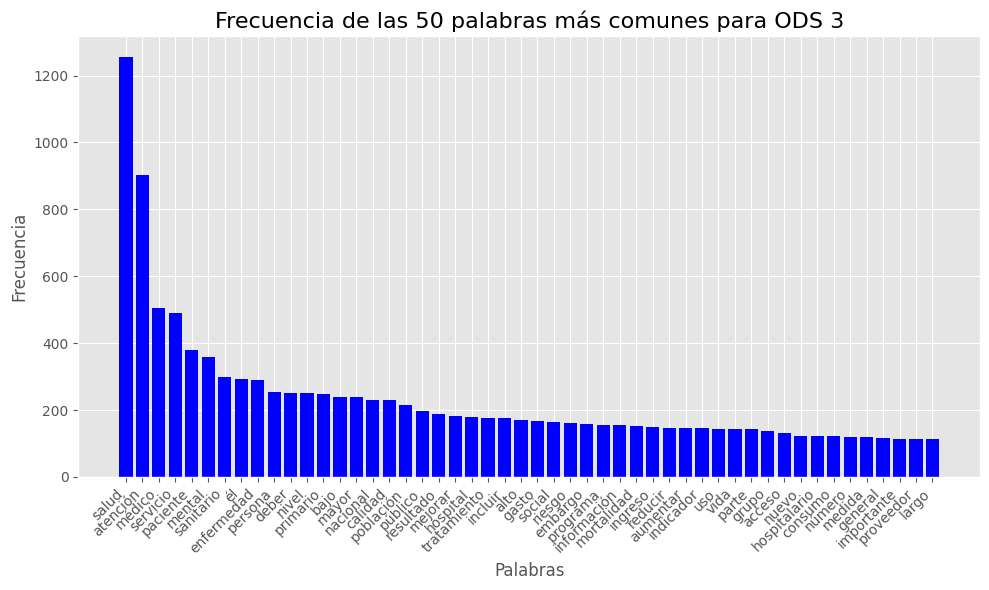

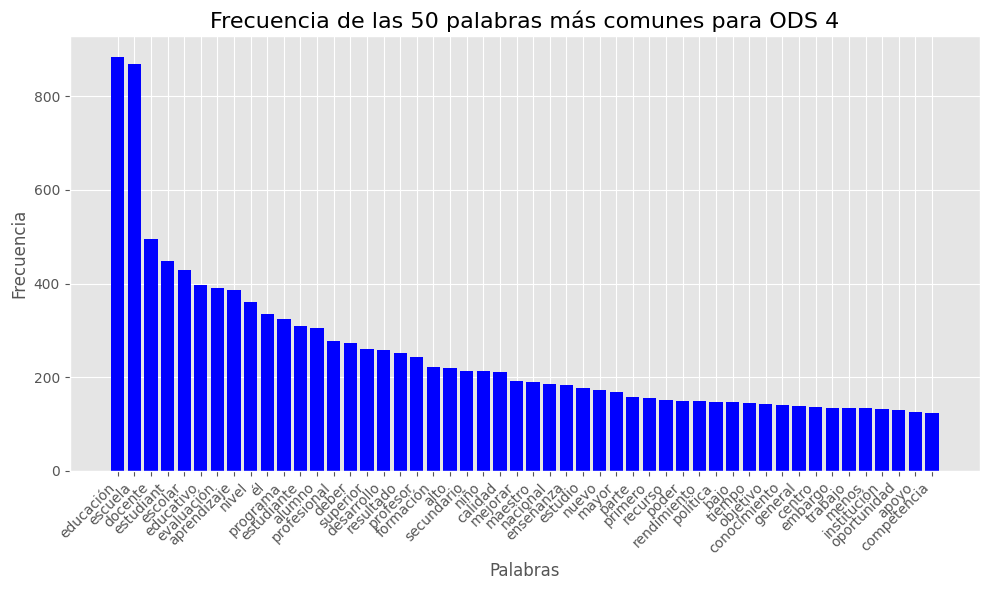


-------------------------------------------------------------
Palabras comunes en el top 50 de cada ODS:
['alto', 'él', 'bajo', 'nivel', 'nacional', 'deber', 'embargo', 'mayor', 'resultado']
-------------------------------------------------------------


<Figure size 640x480 with 0 Axes>


Estadísticas de longitud de textos:
 - Total de textos: 3075
 - Palabras mínimas: 19
 - Palabras máximas: 118
 - Promedio de palabras: 52.28
 - Mediana de palabras: 49.0

Estadísticas por categoría ODS:
         mean  median  count
labels                      
1       52.27    50.0   1025
3       52.05    49.0   1025
4       52.53    49.0   1025


In [18]:
generar_analisis_texto(df)

### 1.11 TF-IDF
Se aplica Frecuencia de Término - Frecuencia Inversa de Documento para vectorizar los textos y así convertir las palabras en representaciones numéricas, además de asignar pesos a las palabras que reconozcan sus importancias en cada texto.
Esto crea una nueva matriz que podrá ser usada más adelante por los modelos, junto con el dataframe.

In [19]:
# Se instancia el TfidfVectorizer
vectorizer = TfidfVectorizer()

# Se ajusta y se transforma el texto del DataFrame
tfidf_matrix = vectorizer.fit_transform(df['textos'])

# Ver la forma de la matriz TF-IDF
print("Dimensiones de la matriz TF-IDF:", tfidf_matrix.shape)

# Ver las palabras (features) que se crearon
features = vectorizer.get_feature_names_out()
print("Las 10 primeras palabras (features):", features[:10])

Dimensiones de la matriz TF-IDF: (3075, 9152)
Las 10 primeras palabras (features): ['aalto' 'aaltonir' 'aarkrog' 'aarrevaar' 'abajo' 'abalde' 'abandonado'
 'abandonar' 'abandonarar' 'abandonir']


### 1.12 Procesamiento de los datos de prueba
Por último, como los datos de entrenamiento están listos, se replica el mismo proceso con los datos de prueba para tener ambos datasets listos para usar con los modelos.

In [20]:
df_test = pd.read_excel('./Datos de prueba_proyecto.xlsx')
df_test_svm = df_test.copy()
df_test['textos'] = df_test['Textos_espanol'].astype(pd.StringDtype())
df_test.drop('Textos_espanol', axis=1, inplace=True)
print("Forma del dataset:", df_test.shape)
display(df_test.dtypes)
print("Valores nulos por columna:")
print(df_test.isnull().sum())
print("\nPorcentaje de nulos por columna:")
print((df_test.isnull().sum() / len(df_test) * 100).round(2))
filas_con_nulos = df_test[df_test.isnull().any(axis=1)]
print(f"\nNúmero de filas con valores nulos: {len(filas_con_nulos)}")
filas_con_texto_vacio = df_test[df_test['textos'] == '']
print(f"\nNúmero de filas con texto vacío: {len(filas_con_texto_vacio)}")
duplicados_totales = df_test.duplicated()
print(f"Filas duplicadas exactas: {duplicados_totales.sum()}")
duplicados_texto = df_test.duplicated(subset=['textos'])
print(f"Filas con texto duplicado: {duplicados_texto.sum()}")
df_test['textos'] = df_test['textos'].apply(preprocesar_texto)
df_test['num_palabras'] = df_test['textos'].apply(contar_palabras)
df_test['textos'] = df_test['textos'].apply(eliminar_stopwords)
df_test['num_palabras'] = df_test['textos'].apply(contar_palabras)
df_test['textos'] = df_test['textos'].apply(lematizar_texto)
tfidf_matrix_test = vectorizer.transform(df_test['textos'])
print("Dimensiones de la matriz TF-IDF del conjunto de prueba:", tfidf_matrix_test.shape)

Forma del dataset: (152, 1)


,0
textos,string[python]


Valores nulos por columna:
textos    0
dtype: int64

Porcentaje de nulos por columna:
textos    0.0
dtype: float64

Número de filas con valores nulos: 0

Número de filas con texto vacío: 0
Filas duplicadas exactas: 0
Filas con texto duplicado: 0
Dimensiones de la matriz TF-IDF del conjunto de prueba: (152, 9152)


### 1.13 Visualización de los datos de prueba
A continuación se revisa el estado final del dataframe de prueba.

In [21]:
df_test.shape
df_test.info()
df_test.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   textos        152 non-null    object
 1   num_palabras  152 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.5+ KB


,textos,num_palabras
count,152,152.000000
unique,152,NaN
top,rector representante local ministerio educació...,NaN
freq,1,NaN
mean,NaN,52.250000
std,NaN,17.283476
min,NaN,24.000000
25%,NaN,40.000000
50%,NaN,48.000000
75%,NaN,60.250000


In [22]:
df_test.head(10)

,textos,num_palabras
0,rector representante local ministerio educació...,46
1,contar programa antipobrezar condición incluso...,30
2,debido gran medida invisible forma trabajo inf...,46
3,recurso aún limitado sector servicio privado f...,32
4,período educación primario secundario terciari...,27
5,región asia pacífico casi niño año menos inmun...,28
6,combinación representar oportunidad alumno ind...,49
7,además llevar cabo práctica seguimiento calida...,40
8,alcance visión holístico basar avance logrado ...,65
9,vea él c correa protecting test data for pharm...,47


No se encontró la columna de etiquetas. Saltando análisis por categoría.


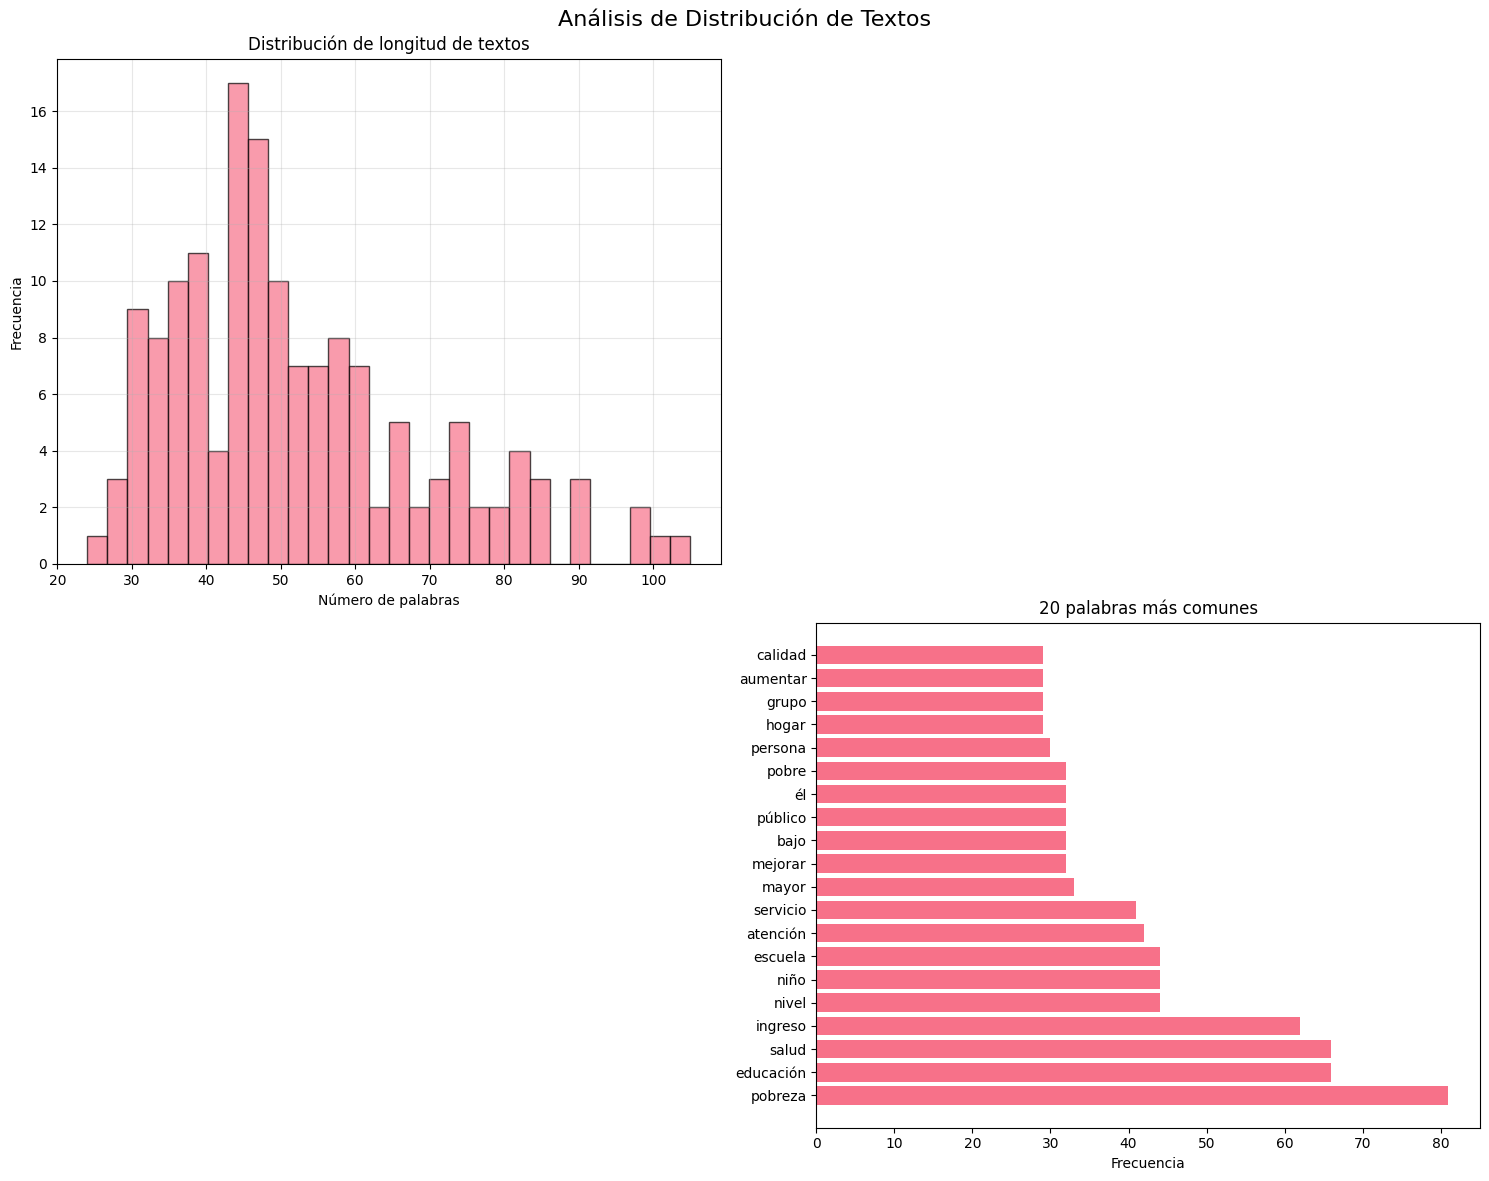


Estadísticas de longitud de textos:
 - Total de textos: 152
 - Palabras mínimas: 24
 - Palabras máximas: 105
 - Promedio de palabras: 52.25
 - Mediana de palabras: 48.0


In [23]:
generar_analisis_texto(df_test)

## **Etapa 2: Modelado y evaluación**
Por:
* Juan Esteban Álvarez García
* Ivan
* Camilo Inoue Rudas

### 2.1 Modelado con Support Vector Machines (SVM)
Por Juan Esteban Álvarez García

#### 2.1.1 Decisión del modelo SVM
Se optó por usar SVM porque estos modelos son particularmente efectivos en espacios de alta dimensionalidad y manejan con facilidad las matrices TF-IDF (que tienen alta dimensionalidad).

Las SVM son excelentes encontrando los mejores hiperplanos que separen las clases y funcionarán muy bien con el procesamiento relaizado sobre los datos.

#### 2.1.2 Preparación del modelo SVM

In [24]:
import openpyxl

from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV

## 1. Grid Search para encontrar los mejores hiperparámetros
print("Iniciando Grid Search para encontrar los mejores hiperparámetros...")

# Definir los parámetros a probar. 'C' es el más importante para SVC.
param_grid = {'C': [0.1, 1, 10, 100]}

# Instanciar el modelo base
svm_model = SVC(kernel='linear', random_state=42)

# Configurar GridSearchCV para la búsqueda
# 'cv=5' significa que usará validación cruzada de 5 pliegues
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)

# Entrenar el Grid Search con el conjunto completo de entrenamiento
grid_search.fit(tfidf_matrix, df['labels'])

print("Búsqueda de hiperparámetros finalizada.")
print(f"Mejor valor de C encontrado: {grid_search.best_params_['C']}")
print(f"Mejor F1-score (macro) en validación cruzada: {grid_search.best_score_:.5f}")

Iniciando Grid Search para encontrar los mejores hiperparámetros...
Búsqueda de hiperparámetros finalizada.
Mejor valor de C encontrado: 10
Mejor F1-score (macro) en validación cruzada: 0.98861


#### 2.1.3 Entrenar sobre los datos de entrenamiento

In [25]:
# Dividir el conjunto de entrenamiento en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(
    tfidf_matrix,
    df['labels'],
    test_size=0.2,
    random_state=42,
    stratify=df['labels']
)

# Entrenar el modelo con el nuevo conjunto de entrenamiento
print("Entrenando el modelo SVM...")
model_svm = SVC(kernel='linear', C=grid_search.best_params_['C'], random_state=42)
model_svm.fit(X_train, y_train)
print("¡Entrenamiento completado!")

Entrenando el modelo SVM...
¡Entrenamiento completado!


#### 2.1.4 Validar sobre los datos de entrenamiento

In [26]:
# Realizar predicciones sobre el conjunto de validación
print("\nRealizando predicciones sobre el conjunto de validación...")
predicciones_val = model_svm.predict(X_val)
print("¡Predicciones completadas!")

# Evaluar el rendimiento del modelo con las métricas
print("\nMatriz de Confusión en el conjunto de validación:")
matriz_conf = confusion_matrix(y_val, predicciones_val)
df_matriz_conf = pd.DataFrame(matriz_conf,
                              index=[f'Verdadero ODS {l}' for l in sorted(df['labels'].unique())],
                              columns=[f'Predicho ODS {l}' for l in sorted(df['labels'].unique())])
print(df_matriz_conf)

print("\nReporte de Clasificación en el conjunto de validación:")
print(classification_report(y_val, predicciones_val))


Realizando predicciones sobre el conjunto de validación...
¡Predicciones completadas!

Matriz de Confusión en el conjunto de validación:
                 Predicho ODS 1  Predicho ODS 3  Predicho ODS 4
Verdadero ODS 1             201               3               1
Verdadero ODS 3               1             200               4
Verdadero ODS 4               1               2             202

Reporte de Clasificación en el conjunto de validación:
              precision    recall  f1-score   support

           1       0.99      0.98      0.99       205
           3       0.98      0.98      0.98       205
           4       0.98      0.99      0.98       205

    accuracy                           0.98       615
   macro avg       0.98      0.98      0.98       615
weighted avg       0.98      0.98      0.98       615



Dado que la matriz de confusión muestra resultados buenos y las métricas de precisión, recall, accuracy y f1-score fueron todas altas, se observa que el modelo tuvo un excelente rendimiento.

Esto puede indicar que el modelo incurrió en Overfitting o que en realidad aprendió muy bien de los datos y está listo para el dataset de prueba.

#### 2.1.5 Entrenar sobre los datos de prueba
Dado que el rendimiento del modelo fue bueno, se decide usarlo sobre los datos de prueba para comprobar su rendimiento con datos nuevos que no ha visto.

In [27]:
# Entrenar el modelo con los datos de entrenamiento
print("Entrenando el modelo SVM...")
model_svm.fit(tfidf_matrix, df['labels'])
print("¡Entrenamiento completado!")

Entrenando el modelo SVM...
¡Entrenamiento completado!


#### 2.1.6 Validar sobre los datos de prueba

In [28]:
# Realizar predicciones sobre el conjunto de prueba
print("\nRealizando predicciones sobre el conjunto de prueba...")
predicciones = model_svm.predict(tfidf_matrix_test)
print("¡Predicciones completadas!")
df_test_svm['predicciones_ods'] = predicciones

# Mostrar las predicciones
print("\nPredicciones del modelo para el conjunto de prueba:")
print(df_test_svm[['Textos_espanol', 'predicciones_ods']].head(20))
print(df_test_svm['predicciones_ods'].value_counts())

# Guardar el DataFrame con los resultados en un archivo de Excel
df_test_svm.to_excel('predicciones_svm.xlsx', index=False)
print("¡Archivo de Excel con los resultados guardado exitosamente!")
print("Puedes abrir 'resultados_predicciones.xlsx' para ver los textos completos y las predicciones.")


Realizando predicciones sobre el conjunto de prueba...
¡Predicciones completadas!

Predicciones del modelo para el conjunto de prueba:
                                       Textos_espanol  predicciones_ods
0   El rector, que es el representante local del M...                 4
1   Tenga en cuenta que todos los programas antipo...                 3
2   Debido a que son en gran medida invisibles, es...                 1
3   Los recursos aún son limitados en este sector....                 4
4   Durante el período 1985-2008, la educación pri...                 4
5   En la región de Asia y el Pacífico, casi el 87...                 3
6   Esta combinación representa una oportunidad pa...                 4
7   Además, muchos llevan a cabo prácticas de segu...                 4
8   El alcance de esta visión holística se basa en...                 4
9   Véase C. Correa, "Protecting Test Data for Pha...                 3
10  En 2012, alrededor del 10 % de la variación en...                 4


Luego de revisar algunos de los resultados manualmente, se puede ver que las buenas métricas del anterior entrenamiento no fueron síntoma de Overfitting sino que el modelo realmente aprendió de los datos y es exitoso y apto para datos nuevos no vistos.

### 2.2 Modelado con LinearSVC

Ivan Arturo Avila Gomez

#### 2.2.1 Justificacion LinearSVC


LinearSVC es un algoritmo especialmente eficaz para la clasificación de textos representados con TF-IDF, dado que maneja adecuadamente la alta dimensionalidad y la dispersión de los datos. Ofrece un equilibrio óptimo entre precisión, eficiencia de entrenamiento y capacidad de generalización en escenarios con desbalance de clases, permitiendo identificar las palabras más relevantes para cada predicción y facilitando el reentrenamiento y despliegue continuo que exige el proyecto

####2.2.2 Preparacion del modelo

In [29]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix


In [30]:
X_train, X_val, y_train, y_val = train_test_split(
    tfidf_matrix,
    df['labels'],
    test_size=0.2,
    random_state=42,
    stratify=df['labels']
)

####2.2.3 Conjunto de valores a probar para el parametro regularizador C de LinearSVC

In [31]:
svc = LinearSVC(dual=True)
param_grid = {
    "C": [0.25, 0.5, 1.0, 2.0, 4.0],
}

####2.2.4 Busqueda mejor parametro C

In [32]:

gs = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1
)
print("Buscando mejor C para LinearSVC...")
gs.fit(X_train, y_train)
best_svc = gs.best_estimator_
print(f"Mejor C: {gs.best_params_['C']}")

Buscando mejor C para LinearSVC...
Mejor C: 0.5


####2.2.5 Validar sobre los datos de entrenamiento

In [33]:
y_pred = best_svc.predict(X_val)
print("\n LinearSVC")
print("Accuracy:", accuracy_score(y_val, y_pred))
print("F1-macro:", f1_score(y_val, y_pred, average="macro"))
print(classification_report(y_val, y_pred))

cm = confusion_matrix(y_val, y_pred)

labels =  ['ODS 1', 'ODS 3', 'ODS 4']

cm_df = pd.DataFrame(
    cm,
    index=[f"Verdadero {l}" for l in labels],
    columns=[f"Predicho {l}" for l in labels]
)

print("\nMatriz de Confusión en el conjunto de validación:")
print(cm_df)


 LinearSVC
Accuracy: 0.9869918699186991
F1-macro: 0.9869918699186991
              precision    recall  f1-score   support

           1       0.99      0.99      0.99       205
           3       0.99      0.99      0.99       205
           4       0.99      0.99      0.99       205

    accuracy                           0.99       615
   macro avg       0.99      0.99      0.99       615
weighted avg       0.99      0.99      0.99       615


Matriz de Confusión en el conjunto de validación:
                 Predicho ODS 1  Predicho ODS 3  Predicho ODS 4
Verdadero ODS 1             203               1               1
Verdadero ODS 3               1             202               2
Verdadero ODS 4               1               2             202


####2.2.6 Validar sobre los datos de prueba

In [34]:
# 1) Mejor modelo entrenado por GridSearchCV
modelo_final = best_svc

# 2) Predicción sobre el conjunto de prueba (misma representación TF-IDF)
print("\nRealizando predicciones sobre el conjunto de prueba...")
y_pred = modelo_final.predict(tfidf_matrix_test)
print("Predicciones completadas")

# 3) Anexar al DataFrame de prueba y revisar distribución
df_test_svm['predicciones_ods'] = y_pred
print("\nConteo por clase en predicciones:")
print(df_test_svm['predicciones_ods'].value_counts())

cols_vista = [c for c in ['Textos_espanol','textos','predicciones_ods'] if c in df_test_svm.columns]
print("\nMuestra de predicciones:")
print(df_test_svm[cols_vista].head(20))

# 4) Guardar archivo Excel para la entrega
salida_xlsx = 'resultados_predicciones_LinearSvc.xlsx'
df_test_svm.to_excel(salida_xlsx, index=False)
print(f"\nArchivo guardado: {salida_xlsx}")



Realizando predicciones sobre el conjunto de prueba...
Predicciones completadas

Conteo por clase en predicciones:
predicciones_ods
3    52
4    50
1    50
Name: count, dtype: int64

Muestra de predicciones:
                                       Textos_espanol  predicciones_ods
0   El rector, que es el representante local del M...                 4
1   Tenga en cuenta que todos los programas antipo...                 3
2   Debido a que son en gran medida invisibles, es...                 1
3   Los recursos aún son limitados en este sector....                 3
4   Durante el período 1985-2008, la educación pri...                 4
5   En la región de Asia y el Pacífico, casi el 87...                 3
6   Esta combinación representa una oportunidad pa...                 4
7   Además, muchos llevan a cabo prácticas de segu...                 4
8   El alcance de esta visión holística se basa en...                 4
9   Véase C. Correa, "Protecting Test Data for Pha...                 3

###2.3 Modelado Logistic Regression

Ivan Avila



Logistic Regression maneja eficientemente representaciones de texto de alta dimensionalidad como TF-ID, tambien, permitir obtener probabilidades asociadas a cada predicción, lo cual facilita interpretar el nivel de confianza del modelo y ajustar umbrales de decisión según el contexto. Además, es un método robusto, ampliamente validado en clasificación de textos, escalable a grandes volúmenes de datos y menos propenso al sobreajuste si se aplica una regularización adecuada, lo que lo convierte en un complemento sólido y contrastante frente a otros algoritmos probados en el proyecto.

####2.3.1 Imports

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import pandas as pd

####2.3.2 Entrenamiento del modelo

In [36]:
logreg = LogisticRegression(
    solver="saga",
    penalty="l2",
    max_iter=5000,
    class_weight="balanced",
    random_state=42
)
logreg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=5000, random_state=42,
                   solver='saga')

####2.3.3 Evaulacion y validacion

In [37]:
y_pred_log = logreg.predict(X_val)

print("\n== Logistic Regression ==")
print("Accuracy:", accuracy_score(y_val, y_pred_log))
print("F1-macro:", f1_score(y_val, y_pred_log, average="macro"))
print(classification_report(y_val, y_pred_log))


== Logistic Regression ==
Accuracy: 0.9821138211382113
F1-macro: 0.982121685261255
              precision    recall  f1-score   support

           1       0.99      0.99      0.99       205
           3       0.98      0.98      0.98       205
           4       0.98      0.98      0.98       205

    accuracy                           0.98       615
   macro avg       0.98      0.98      0.98       615
weighted avg       0.98      0.98      0.98       615



In [38]:
labels = sorted(y_val.unique())
cm = confusion_matrix(y_val, y_pred_log, labels=labels)
cm_df = pd.DataFrame(
    cm,
    index=[f"Verdadero {l}" for l in labels],
    columns=[f"Predicho {l}" for l in labels]
)
print("\nMatriz de Confusión:")
print(cm_df)


Matriz de Confusión:
             Predicho 1  Predicho 3  Predicho 4
Verdadero 1         202           1           2
Verdadero 3           1         201           3
Verdadero 4           1           3         201


In [39]:
#Probabilidades
y_proba_log = logreg.predict_proba(X_val)

y_proba_log

array([[0.14671018, 0.15868662, 0.6946032 ],
       [0.88742464, 0.06959628, 0.04297907],
       [0.7493754 , 0.1372945 , 0.1133301 ],
       ...,
       [0.99503515, 0.00221744, 0.00274741],
       [0.99196249, 0.00506415, 0.00297336],
       [0.91383817, 0.03999897, 0.04616286]])

In [40]:
# Predicciones con Logistic Regression y exportar resultados a Excel
col_texto = 'textos' if 'textos' in df_test.columns else 'Textos_espanol'
X_test = vectorizer.transform(df_test[col_texto])

y_pred_log = logreg.predict(X_test)
y_proba_log = logreg.predict_proba(X_test)

salida = df_test.copy()
salida['prediccion_logreg'] = y_pred_log
for i, c in enumerate(logreg.classes_):
    salida[f'proba_{c}'] = y_proba_log[:, i]

salida.to_excel('resultados_predicciones_logreg.xlsx', index=False)
print("Archivo guardado: resultados_predicciones_logreg.xlsx")


Archivo guardado: resultados_predicciones_logreg.xlsx


La incorporación de probabilidades en la Regresión Logística no solo permite asignar una clase a cada opinión, sino también cuantificar el nivel de confianza del modelo en su decisión. Esto aporta un valor adicional frente a algoritmos como LinearSVC, que no generan probabilidades directamente, ya que facilita la interpretación de resultados, el ajuste de umbrales de decisión y la identificación de casos inciertos que requieren revisión. Para la etapa 2 del proyecto, estas probabilidades se convierten en una parte clave para que la aplicación final entregue predicciones más transparentes y útiles para los usuarios, alineadas con la necesidad de apoyar decisiones informadas respecto a los ODS.

### 2.4 Modelado Random Forest
Por Camilo Inoue

#### 2.4.1 Decisión del modelo Random Forest
Se decidió utilizar el algoritmo Random Forest porque, al usar árboles de desición que fueron entrenados con características y datos distintos y luego se juntan las predicciones de cada uno de ellos, se reduce la varianza sin aumentar el sesgo demasiado.

Random Forest es robusto ante casos de sobreajuste, lo que lo hace una opción llamativa.

####2.4.2 Preparación del modelo SVM

In [41]:
import pandas as pd
import openpyxl
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Dividir el conjunto en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(
    tfidf_matrix,
    df['labels'],
    test_size=0.2,
    random_state=42,
    stratify=df['labels']
)

# Instanciar el modelo Random Forest
model_rf = RandomForestClassifier(
    n_estimators=200,   # número de árboles
    max_depth=None,     # sin límite de profundidad
    random_state=42,
    n_jobs=-1
)

####2.4.3 Entrenar sobre los datos de entrenamiento

In [42]:
print("Entrenando el modelo Random Forest...")
model_rf.fit(X_train, y_train)
print("¡Entrenamiento completado!")

Entrenando el modelo Random Forest...
¡Entrenamiento completado!


####2.4.4 Validar sobre los datos de entrenamiento

In [43]:
# Predicciones en validación
predicciones_val = model_rf.predict(X_val)

# Evaluación del modelo
matriz_conf = confusion_matrix(y_val, predicciones_val)
df_matriz_conf = pd.DataFrame(matriz_conf,
                              index=[f'Verdadero ODS {l}' for l in sorted(df['labels'].unique())],
                              columns=[f'Predicho ODS {l}' for l in sorted(df['labels'].unique())])

print(df_matriz_conf)
print(classification_report(y_val, predicciones_val))

                 Predicho ODS 1  Predicho ODS 3  Predicho ODS 4
Verdadero ODS 1             204               1               0
Verdadero ODS 3               1             202               2
Verdadero ODS 4               1               1             203
              precision    recall  f1-score   support

           1       0.99      1.00      0.99       205
           3       0.99      0.99      0.99       205
           4       0.99      0.99      0.99       205

    accuracy                           0.99       615
   macro avg       0.99      0.99      0.99       615
weighted avg       0.99      0.99      0.99       615



####2.4.5 Entrenar sobre los datos de prueba

In [44]:
print("Entrenando el modelo final Random Forest con todos los datos...")
model_rf.fit(tfidf_matrix, df['labels'])
print("¡Entrenamiento completado!")

Entrenando el modelo final Random Forest con todos los datos...
¡Entrenamiento completado!


####2.4.5 Validar sobre los datos de prueba

In [45]:
# Predicciones sobre el conjunto de prueba
predicciones = model_rf.predict(tfidf_matrix_test)

df_test_rf = df_test.copy()
df_test_rf['predicciones_ods'] = predicciones

# Mostrar resultados
print(df_test_rf[['predicciones_ods']].head(20))
print(df_test_rf['predicciones_ods'].value_counts())

# Guardar resultados
df_test_rf.to_excel('predicciones_rf.xlsx', index=False)

    predicciones_ods
0                  4
1                  4
2                  1
3                  4
4                  4
5                  3
6                  4
7                  4
8                  4
9                  3
10                 4
11                 4
12                 1
13                 4
14                 4
15                 3
16                 4
17                 4
18                 1
19                 3
predicciones_ods
4    52
1    50
3    50
Name: count, dtype: int64


##3 Pipeline
Ivan Ávila


El modelo LinearSVC fue seleccionado como algoritmo final ya que alcanzó el mejor
desempeño entre los modelos evaluados, con un F1-macro cercano al 0.99, superando
ligeramente a la Regresión Logística y al Random Forest. Sus métricas de precisión y recall
fueron consistentes en las tres clases (ODS 1, ODS 3 y ODS 4), lo que confirma un
comportamiento equilibrado y confiable.

Además, LinearSVC se adapta de manera eficiente a la representación TF-IDF, escalando
adecuadamente en escenarios de alta dimensionalidad y dispersión propios de datos
textuales. A diferencia de Random Forest, que requiere mayor costo computacional, y de
la Regresión Logística, que mostró métricas ligeramente inferiores, LinearSVC asegura un
balance óptimo entre rendimiento, eficiencia y capacidad de generalización, por lo cual
se justifica su elección como el modelo más adecuado para el proyecto.

In [46]:
import joblib
from sklearn.pipeline import Pipeline

In [47]:
# 1. Dividir en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(
    df['textos'], df['labels'],
    test_size=0.2, random_state=42, stratify=df['labels']
)


In [48]:
# 2. Definir pipeline (TF-IDF + LinearSVC)
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(lowercase=True)),
    ('clf', LinearSVC(dual=True, random_state=42))
])

In [49]:
# 3. Grid de hiperparámetros
param_grid = {
    'clf__C': [0.25, 0.5, 0.55, 0.7, 0.8],
    'clf__loss': ['hinge', 'squared_hinge'],
    'tfidf__ngram_range': [(1,1), (1,2)]
}

# 4. GridSearchCV
gs = GridSearchCV(pipe, param_grid, scoring='f1_macro', cv=5, n_jobs=-1)
gs.fit(X_train, y_train)

best_pipe = gs.best_estimator_
print("Mejor configuración:", gs.best_params_)

Mejor configuración: {'clf__C': 0.5, 'clf__loss': 'squared_hinge', 'tfidf__ngram_range': (1, 1)}


In [50]:
# 5. Evaluación en validación
y_pred = best_pipe.predict(X_val)
print("\n== LinearSVC (Pipeline) ==")
print("Accuracy:", accuracy_score(y_val, y_pred))
print("F1-macro:", f1_score(y_val, y_pred, average="macro"))
print(classification_report(y_val, y_pred))

# Matriz de confusión
labels_ord = sorted(y_val.unique())
cm = confusion_matrix(y_val, y_pred, labels=labels_ord)
cm_df = pd.DataFrame(cm,
    index=[f"Verdadero ODS {l}" for l in labels_ord],
    columns=[f"Predicho ODS {l}" for l in labels_ord]
)
print("\nMatriz de Confusión:\n", cm_df)



== LinearSVC (Pipeline) ==
Accuracy: 0.9869918699186991
F1-macro: 0.9869918699186991
              precision    recall  f1-score   support

           1       0.99      0.99      0.99       205
           3       0.99      0.99      0.99       205
           4       0.99      0.99      0.99       205

    accuracy                           0.99       615
   macro avg       0.99      0.99      0.99       615
weighted avg       0.99      0.99      0.99       615


Matriz de Confusión:
                  Predicho ODS 1  Predicho ODS 3  Predicho ODS 4
Verdadero ODS 1             203               1               1
Verdadero ODS 3               1             202               2
Verdadero ODS 4               1               2             202


In [51]:
joblib.dump(best_pipe, "pipeline_linearsvc.joblib")
print("\nPipeline guardado como pipeline_linearsvc.joblib")


Pipeline guardado como pipeline_linearsvc.joblib


El modelo LinearSVC, seleccionado como el mejor algoritmo, alcanzó un accuracy del 98,7% y un F1-macro de 0,987, valores que reflejan un buen desempeño  y equilibrado en la clasificación de opiniones entre los ODS 1, 3 y 4. Las métricas de precisión, recall y f1-score fueron de 0,99 en todas las clases, lo que indica que el modelo clasifica correctamente la gran mayoría de los textos y mantiene un balance adecuado entre falsos positivos y falsos negativos.

La matriz de confusión evidencia que los errores de clasificación fueron mínimos (1 a 2 casos por clase), lo que confirma la robustez del modelo y su capacidad de generalización. Este nivel de rendimiento garantiza que las opiniones ciudadanas se asignen de manera confiable a los objetivos correspondientes.

En términos de impacto para la organización, contar con un modelo con métricas tan consistentes permite automatizar el análisis de grandes volúmenes de opiniones, reduciendo el esfuerzo manual y facilitando la toma de decisiones basada en evidencia. Al relacionar de forma precisa los textos con los ODS, la organización puede priorizar recursos, identificar problemáticas críticas y diseñar estrategias alineadas con la Agenda 2030 de Desarrollo Sostenible, apoyando directamente la consecución de los objetivos de negocio y de política pública

## 4 Resultados
Iván Ávila

###4.1 Análisis de las palabras identificadas para relacionar las opiniones con los ODS

In [52]:
vect = best_pipe.named_steps["tfidf"]
clf  = best_pipe.named_steps["clf"]

feature_names = vect.get_feature_names_out()
coef = clf.coef_  # shape: (n_clases, n_features)

def top_terms(coefs, feat_names, k=15):
    idx = coefs.argsort()[::-1][:k]
    return pd.DataFrame({"termino": feat_names[idx], "peso": coefs[idx].round(4)})

tablas_top = {}
for i, cls in enumerate(clf.classes_):
    tablas_top[cls] = top_terms(coef[i], feature_names, k=15)
    print(f"\nTop palabras para ODS {cls}")
    display(tablas_top[cls])



Top palabras para ODS 1


,termino,peso
0,pobreza,3.8724
1,pobre,2.4116
2,pobrezar,2.0962
3,privación,1.7810
4,hogar,1.5155
5,protección,1.1817
6,social,1.1670
7,ingreso,1.0875
8,ipm,0.9566
9,transferencia,0.9396



Top palabras para ODS 3


,termino,peso
0,salud,3.8036
1,médico,2.0784
2,atención,1.9472
3,sanitario,1.7251
4,paciente,1.6332
5,enfermedad,1.5004
6,mortalidad,1.4546
7,mental,1.4083
8,alcohol,1.3796
9,hospital,1.3426



Top palabras para ODS 4


,termino,peso
0,educación,2.7425
1,escuela,2.5919
2,educativo,2.0846
3,estudiant,1.9457
4,alumno,1.5880
5,docente,1.4437
6,profesor,1.3994
7,aprendizaje,1.3103
8,escolar,1.2878
9,enseñanza,1.2287


In [53]:
for cls, df_top in tablas_top.items():
    df_top.to_csv(f"top_palabras_ODS_{cls}.csv", index=False)

El análisis de las palabras más relevantes identificadas por el modelo LinearSVC muestra cómo ciertos términos guían la clasificación de las opiniones hacia cada ODS. Para ODS 1, destacan términos relacionados con ingresos, empleo, pobreza, hogar y ayudas, lo que refleja que las preocupaciones ciudadanas se concentran en condiciones socioeconómicas básicas. Para ODS 3, predominan palabras vinculadas con hospitales, medicamentos, atención médica y salud en general, lo cual evidencia que la población prioriza la mejora del acceso a servicios de salud y la calidad de la atención. En ODS 4, sobresalen vocablos como escuela, universidad, profesores y formación, señalando que las necesidades percibidas están orientadas al fortalecimiento de la educación básica y superior.

Estos hallazgos permiten a la organización diseñar estrategias específicas y focalizadas. Por ejemplo, para ODS 1 se pueden plantear programas de subsidios o generación de empleo; para ODS 3, reforzar la infraestructura hospitalaria y campañas de salud preventiva; y para ODS 4, destinar recursos a capacitación docente y mejoras en la infraestructura educativa.

La utilidad de esta información radica en que el modelo no solo clasifica las opiniones, sino que también explica qué términos motivan dicha clasificación, facilitando la interpretación de los resultados y su traducción en acciones de política pública más precisas y alineadas con las prioridades ciudadanas, en concordancia con el objetivo del proyecto

### 4.2 Datos de prueba compartidos




In [54]:
COL_TEXTO_TEST = 'textos' if 'textos' in df_test.columns else 'Textos_espanol'

# Predicciones con el pipeline entrenado
pred_test = best_pipe.predict(df_test[COL_TEXTO_TEST])

# Crear DataFrame de salida con columna adicional
df_out = df_test.reset_index(drop=True).copy()
df_out["prediccion_linearsvc"] = pred_test

# Guardar archivo Excel
nombre_xlsx = "resultados_prediccionesFINAL.xlsx"
df_out.to_excel(nombre_xlsx, index=False)

print(f"Archivo guardado: {nombre_xlsx}")
print("Distribución de predicciones:\n", df_out["prediccion_linearsvc"].value_counts())



Archivo guardado: resultados_prediccionesFINAL.xlsx
Distribución de predicciones:
 prediccion_linearsvc
3    52
4    50
1    50
Name: count, dtype: int64
